In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_sub = pd.read_csv('../data/sample_submission.csv')

In [4]:
df_train = df_train.drop(['ID_LAT_LON_YEAR_WEEK'],axis=1)
df_test = df_test.drop(['ID_LAT_LON_YEAR_WEEK'],axis=1)

In [5]:
df_test.shape,df_train.shape

((24353, 74), (79023, 75))

In [6]:
df_test.isnull().sum()

latitude                                       0
longitude                                      0
year                                           0
week_no                                        0
SulphurDioxide_SO2_column_number_density    6142
                                            ... 
Cloud_surface_albedo                         166
Cloud_sensor_azimuth_angle                   166
Cloud_sensor_zenith_angle                    166
Cloud_solar_azimuth_angle                    166
Cloud_solar_zenith_angle                     166
Length: 74, dtype: int64

In [7]:
df_train.isnull().sum()

latitude                                        0
longitude                                       0
year                                            0
week_no                                         0
SulphurDioxide_SO2_column_number_density    14609
                                            ...  
Cloud_sensor_azimuth_angle                    484
Cloud_sensor_zenith_angle                     484
Cloud_solar_azimuth_angle                     484
Cloud_solar_zenith_angle                      484
emission                                        0
Length: 75, dtype: int64

In [8]:
df_train_a = df_train.copy()

In [9]:
df_train = df_train[["latitude", "longitude","year","week_no"]]
df_test  = df_test[["latitude", "longitude","year","week_no"]]

In [10]:
df_train.isnull().sum(),df_test.isnull().sum()

(latitude     0
 longitude    0
 year         0
 week_no      0
 dtype: int64,
 latitude     0
 longitude    0
 year         0
 week_no      0
 dtype: int64)

In [11]:
y = df_train_a['emission'] 
X = df_train 

In [12]:
# Create DMatrix for training data
dtrain_full = xgb.DMatrix(X,label=y)

# Hyperparameters and train the model
params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'logloss',
    'max_depth': 40,    
    'eta': 0.32659,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 1,
    'lambda': 1,
    'tree_method': 'hist'     #gpu_hist 사용불가여서 hist로 바꿈
}
num_rounds = 150

model_full = xgb.train(params, dtrain_full,num_rounds)

# Create DMatrix for test data
dtest = xgb.DMatrix(df_test)

# Make predictions on the test data
y_test_pred_prob = model_full.predict(dtest)

In [13]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
import numpy as np

# Assuming you have your features and target data in X and y, and test data in df_test

# Create a CatBoostRegressor instance
model = CatBoostRegressor(iterations=970,
                          learning_rate=0.023916461397043003,
                          depth=9,
                          l2_leaf_reg=7,
                          random_seed=42
                          )

# Initialize the KFold cross-validator
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Arrays to store predictions and true labels for each fold
predictions = np.zeros(len(X))
true_labels = np.zeros(len(X))
test_predictions = np.zeros(len(df_test))

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Fit the CatBoost model on the training data
    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=50)

    # Predict on the validation data
    fold_preds = model.predict(X_val)

    # Predict on the test data
    fold_test_preds = model.predict(df_test)

    # Store the predictions and true labels for evaluation
    predictions[val_idx] = fold_preds
    true_labels[val_idx] = y_val
    test_predictions += fold_test_preds / n_splits  # Average predictions from all folds

# Calculate the overall evaluation metric (e.g., RMSE) on all folds for the validation data
overall_metric_val = np.sqrt(np.mean((true_labels - predictions) ** 2))
print("Overall RMSE (Validation):", overall_metric_val)

0:	learn: 146.0377688	test: 126.7881747	best: 126.7881747 (0)	total: 210ms	remaining: 3m 23s
100:	learn: 77.4815766	test: 74.2773841	best: 74.2773841 (100)	total: 1.65s	remaining: 14.2s
200:	learn: 62.3142765	test: 61.6895512	best: 61.6895512 (200)	total: 3.16s	remaining: 12.1s
300:	learn: 53.8486572	test: 54.0135753	best: 54.0135753 (300)	total: 4.62s	remaining: 10.3s
400:	learn: 46.8896073	test: 47.8373979	best: 47.8373979 (400)	total: 6.31s	remaining: 8.95s
500:	learn: 41.8144951	test: 43.0887047	best: 43.0887047 (500)	total: 7.82s	remaining: 7.32s
600:	learn: 37.4653160	test: 39.1789960	best: 39.1789960 (600)	total: 9.28s	remaining: 5.7s
700:	learn: 34.1656148	test: 36.1653138	best: 36.1653138 (700)	total: 10.7s	remaining: 4.12s
800:	learn: 31.6094884	test: 33.8136759	best: 33.8136759 (800)	total: 12.3s	remaining: 2.59s
900:	learn: 29.1468949	test: 31.7316063	best: 31.7316063 (900)	total: 13.8s	remaining: 1.05s
969:	learn: 27.8223613	test: 30.5795702	best: 30.5795702 (969)	total: 1

In [14]:
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.model_selection import KFold

lgbm_model = LGBMRegressor(n_estimators=150,
                           learning_rate=0.2,
                           min_child_samples=40,
                           num_leaves=60
                           )

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

lgbm_predictions = np.zeros(len(X))
lgbm_true_labels = np.zeros(len(X))
lgbm_test_predictions = np.zeros(len(df_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgbm_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    lgbm_fold_preds = lgbm_model.predict(X_val)

    lgbm_fold_test_preds = lgbm_model.predict(df_test)

    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits  

overall_metric_lgbm = np.sqrt(np.mean((lgbm_true_labels - lgbm_predictions) ** 2))
print("overall RMSE (LGBMRegressor):", overall_metric_lgbm)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 63218, number of used features: 4
[LightGBM] [Info] Start training from score 81.821283
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 63218, number of used features: 4
[LightGBM] [Info] Start training from score 82.179043
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the tra

In [15]:
ran=RandomForestRegressor(n_estimators=20,random_state=42)
ran.fit(X,y)
pred_ran=ran.predict(df_test)

In [16]:
pred_ran

array([ 3.26163817,  3.91458217,  4.03880074, ..., 29.6829721 ,
       29.96688505, 29.53778035])

In [17]:
from sklearn.ensemble import ExtraTreesRegressor
# Create an ExtraTreesRegressor model
model = ExtraTreesRegressor(n_estimators=100)
# Train the model
model.fit(X, y)
# Make predictions on the test data
y_test_pred = model.predict(df_test)
y_test_pred


array([ 3.319557 ,  3.9718144,  4.030769 , ..., 29.701365 , 30.297634 ,
       29.404171 ])

In [18]:
ensemble = y_test_pred*0.1 + pred_ran*0.4 +lgbm_test_predictions*0.05 +test_predictions*0.05+y_test_pred_prob*0.4

In [19]:
ensemble

array([ 1.66074145,  3.49642496,  3.39296271, ..., 29.49029351,
       29.92223958, 29.20002596])

In [20]:
df_sub['emission']=ensemble*1.05

In [21]:
df_sub.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,1.743779
1,ID_-0.510_29.290_2022_01,3.671246
2,ID_-0.510_29.290_2022_02,3.562611
3,ID_-0.510_29.290_2022_03,3.657710
4,ID_-0.510_29.290_2022_04,3.842067


In [22]:
submission_fix = df_sub.copy()
submission_fix.loc[df_test['longitude']==29.321,'emission'] = df_train_a.loc[(df_train_a['year']==2021)&(df_train_a['week_no']<=48)&(df_train_a['longitude']==29.321),'emission'].values

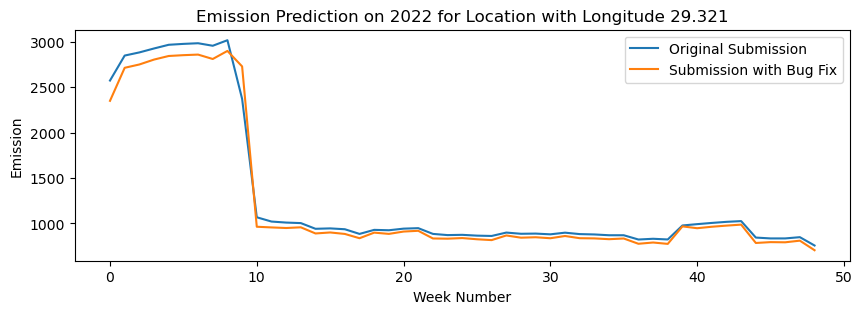

In [23]:
# Plotting the emissions for the original submission
df_sub.loc[df_test['longitude'] == 29.321, 'emission'].reset_index(drop=True).plot(figsize=(10,3),label='Original Submission')

# Plotting the emissions after the bug fix
submission_fix.loc[df_test['longitude'] == 29.321, 'emission'].reset_index(drop=True).plot(figsize=(10,3),label='Submission with Bug Fix')

# Adding legends and labels
plt.xlabel('Week Number')
plt.ylabel('Emission')
plt.title('Emission Prediction on 2022 for Location with Longitude 29.321')
plt.legend()

# Display the plot
plt.show()

In [24]:
df_sub.to_csv('submission.csv',index=False)

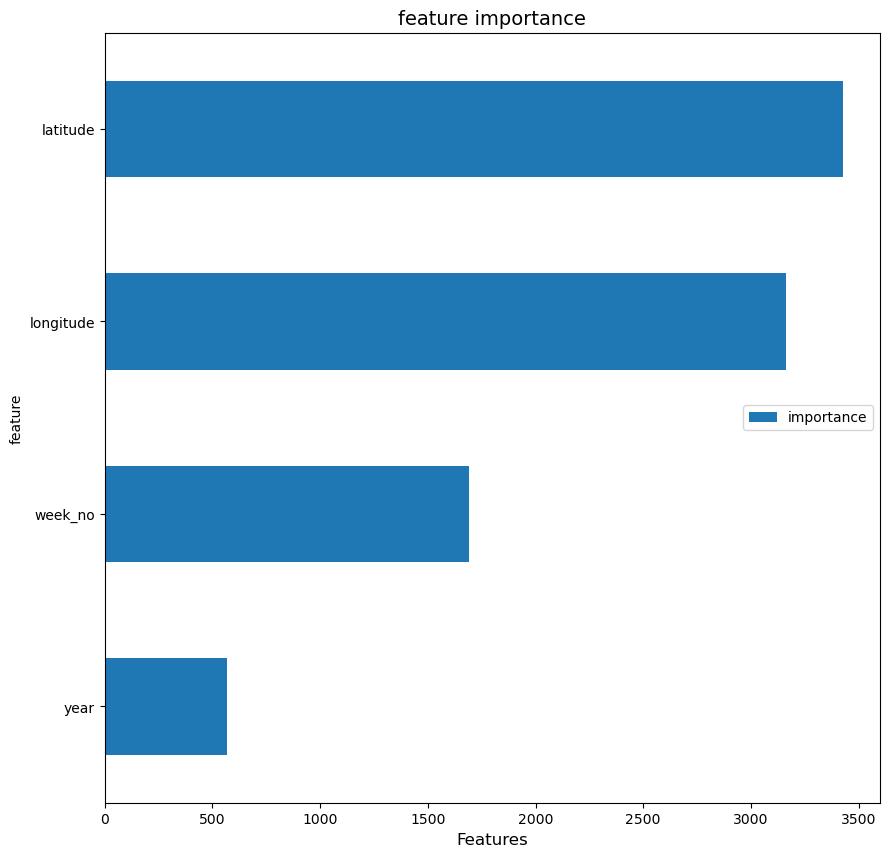

In [25]:
# lightGBM 특성 중요도
impo_df = pd.DataFrame({'feature': X.columns, 'importance': lgbm_model.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()